# Moored ADCP data processing example

This data was recorded with a ADCP by Nortek modelo Aquadopp Profiler of 1000 kHz, moored off Pernambuco shore. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.dates as mdates
import datetime
import scipy.signal as signal

import sys
sys.path.append('d:\guto\gpython\pytools')
import vector_tools as vt

The data downloaded from the ADCP is a binary file '.prf'. This file must be open and converted to ASCII files using the 'Aquapro' software.

The converted files have the same name of the original file, but with different extensions ('a1', 'a2, 'v1', etc.)

In [2]:
'''
path and name of the converted files
'''
root = r'd:\GUTO\1_Trabs\2_Plataforma\PlaPe2\Fundeios_convertidos\\'
name = 'PlaPe_20m_r1.'

#### Instrument setup

In [3]:
'''
getting the instrument configuration from the '.hdr' file
''' 
setup = ['Number of measurements', 'Profile interval', 'Number of cells', 'Cell size', 'Average interval', 'Blanking', 'Wave measurements']
with open(root + name + 'hdr') as f:

    lines = f.read().splitlines()
     
    for li in lines:
        for s in setup:
            if s in li:
                print(li)

        if setup[2] in li:
            number_cells = int(li.split()[3])
        
        if setup[3] in li and 'Wave' not in li:
            cell_size = int(li.split()[2])

        if setup[5] in li:
            blank_distance = float(li.split()[2])

    

Number of measurements                3119
Profile interval                      3600 sec
Number of cells                       25
Cell size                             100 cm
Average interval                      180 sec
Blanking distance                     0.40 m
Wave measurements                     DISABLED
Wave - Cell size                      2.00 m


In [4]:
'''
Level (distance) of the cells measurements from the transudcers based on the setup
'''

cell_size_m = cell_size/100
cell_1 = cell_size_m + blank_distance
max_range = cell_size_m * number_cells + cell_size_m

niveis = np.arange(cell_1, max_range, cell_size_m)
print(len(niveis))
print(niveis)

25
[ 1.4  2.4  3.4  4.4  5.4  6.4  7.4  8.4  9.4 10.4 11.4 12.4 13.4 14.4
 15.4 16.4 17.4 18.4 19.4 20.4 21.4 22.4 23.4 24.4 25.4]


#### Uploading the ASCII files

The ASCII files we need to upload are only numeric, so we can use directly the np.loadtxt

In [5]:
extensions = ['sen', 'v1', 'v2', 'v3', 'a1', 'a2', 'a3']

for ext in extensions:
    
    arq = np.loadtxt(root + name + ext)

    # this trick names the upload date based on the list of 'extensions'
    globals()[ext] = arq
    

### Check the 'when under water'

First check is to know when the instrument was moored... when deploying or recovering, the instrument can record data out of the water. We check the 'pressure' data to learn about that.

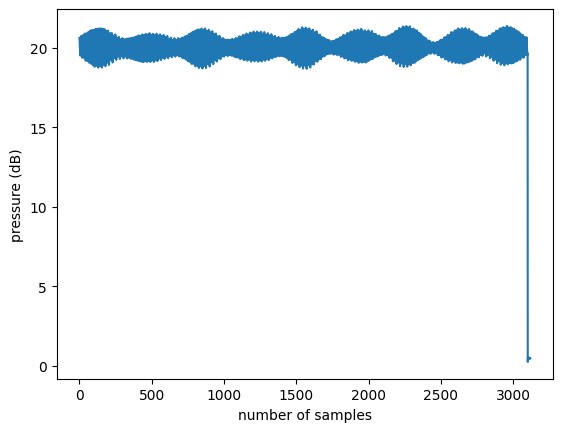

In [6]:
'''
Checking the pressure
'''
plt.plot(sen[:,13])
plt.xlabel('number of samples')
plt.ylabel('pressure (dB)')
plt.show()

We see that the last samples were recorded out of the water. To remove these data, we need just find out the index of the first 'out of water' sample

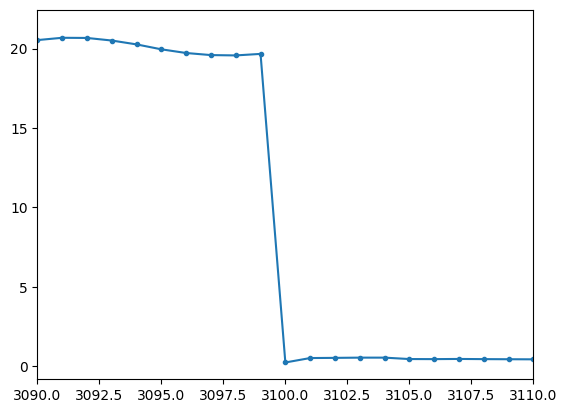

In [7]:
plt.plot(sen[:,13],'.-')
plt.xlim(3090, 3110)
plt.show()

### Selecting the 'good' data

In [8]:
# index of 'goodies'
start = 0
end = 3099

sen = sen[start:end, :]

# here we averaged the acoustic amplitude recorded by the three transducers... sometimes we need to check each one!
amp = (a1 + a2 + a3)/3
amp = amp[start:end,:]

v1 = v1[start:end,:]
v2 = v2[start:end,:]

#### Creating the 'time' object with datetime. It can't be done with 'broadcasting'!

In [9]:
time=[]
for i in range(len(sen)):
    dates = [int(x) for x in sen[i,:5]]
    year = dates[2]
    month = dates[0]
    day = dates[1]
    hour = dates[3] 
    minute = dates[4]
    time.append(
                datetime.datetime(year, month, day, hour, minute)
                )

time = np.array(time)

### Inspecting the 'sen' variables

It is specially important to inspect the orientation/pitch/roll... if there is a jump in the signal, with change of several degrees, it means some sort of mooring displacement. Samll changes are meaningless... big changes can be trouble! Some times overturn of the structure. 

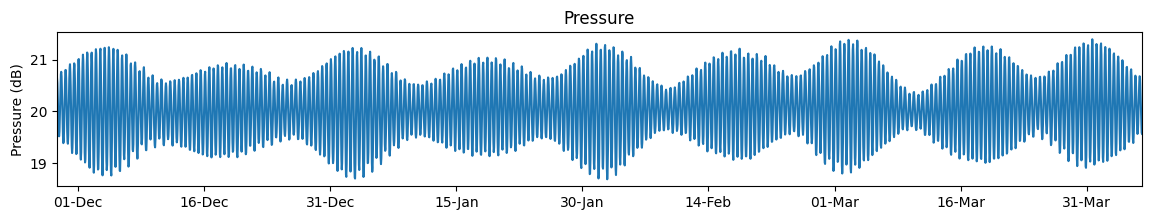

In [10]:
fig, ax = plt.subplots(figsize=(14,2))
ax.plot(time,sen[:,13])
ax.set_title('Pressure')
ax.set_ylabel('Pressure (dB)')
ax.autoscale(enable=True, axis='x', tight=True)

ax.xaxis.set_major_locator(mdates.DayLocator(interval=15))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b'))

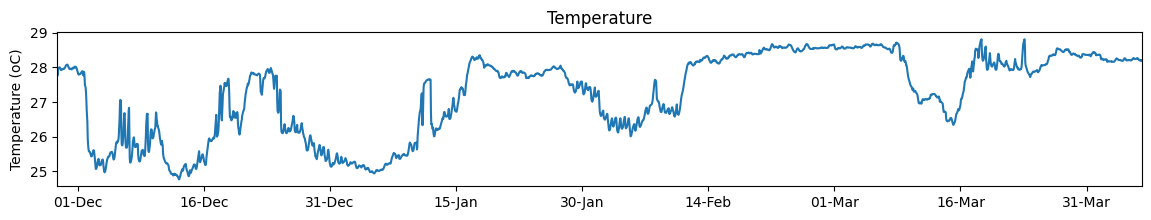

In [11]:
fig, ax = plt.subplots(figsize=(14,2))
ax.plot(time,sen[:,14])
ax.set_title('Temperature')
ax.set_ylabel('Temperature (oC)')
ax.autoscale(enable=True, axis='x', tight=True)

ax.xaxis.set_major_locator(mdates.DayLocator(interval=15))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b'))

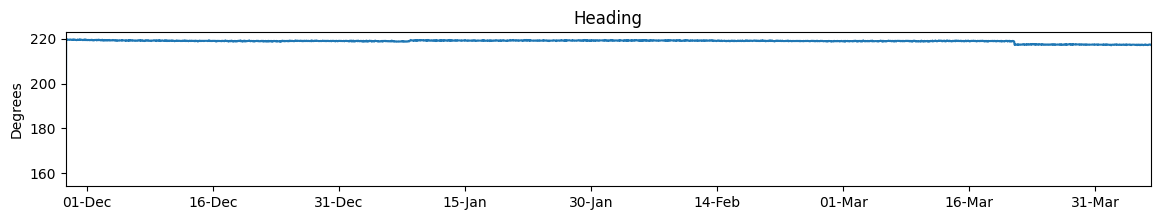

In [12]:
fig, ax = plt.subplots(figsize=(14,2))
ax.plot(time,sen[:,10])
ax.set_title('Heading')
ax.set_ylabel('Degrees')
ax.autoscale(enable=True, axis='x', tight=True)

ax.xaxis.set_major_locator(mdates.DayLocator(interval=15))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b'))

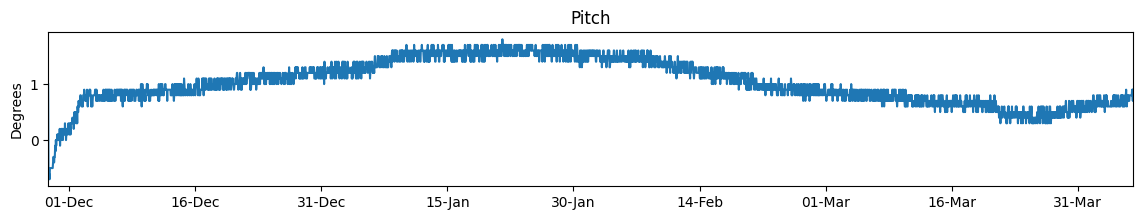

In [13]:
fig, ax = plt.subplots(figsize=(14,2))
ax.plot(time,sen[:,11])
ax.set_title('Pitch')
ax.set_ylabel('Degrees')
ax.autoscale(enable=True, axis='x', tight=True)

ax.xaxis.set_major_locator(mdates.DayLocator(interval=15))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b'))

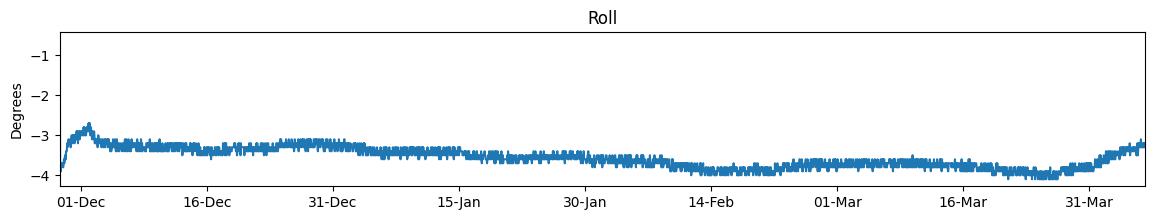

In [14]:
fig, ax = plt.subplots(figsize=(14,2))
ax.plot(time,sen[:,12])
ax.set_title('Roll')
ax.set_ylabel('Degrees')
ax.autoscale(enable=True, axis='x', tight=True)

ax.xaxis.set_major_locator(mdates.DayLocator(interval=15))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b'))

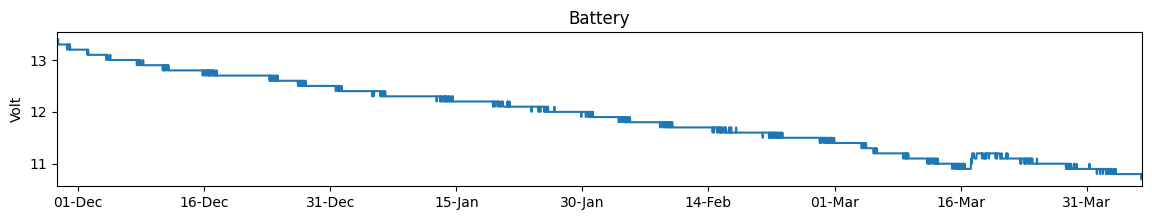

In [15]:
fig, ax = plt.subplots(figsize=(14,2))
ax.plot(time,sen[:,8])
ax.set_title('Battery')
ax.set_ylabel('Volt')
ax.autoscale(enable=True, axis='x', tight=True)

ax.xaxis.set_major_locator(mdates.DayLocator(interval=15))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b'))

### Inspecting the Amplitude, V1 (east-west) and V2 (north-south)

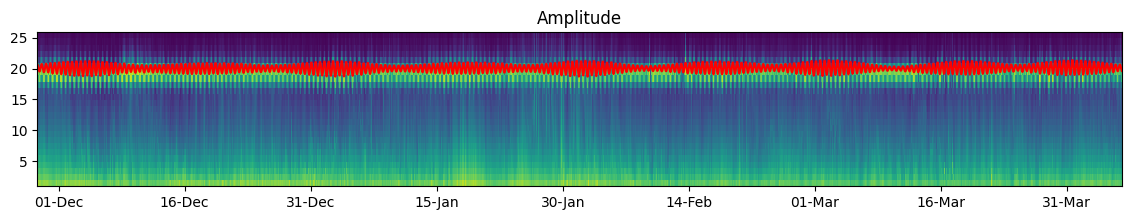

In [16]:
fig, ax = plt.subplots(figsize=(14,2))
ax.pcolormesh(time, niveis, amp.T)
ax.set_title('Amplitude')
ax.plot(time,sen[:,13],'r')

ax.xaxis.set_major_locator(mdates.DayLocator(interval=15))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b'))
plt.show()

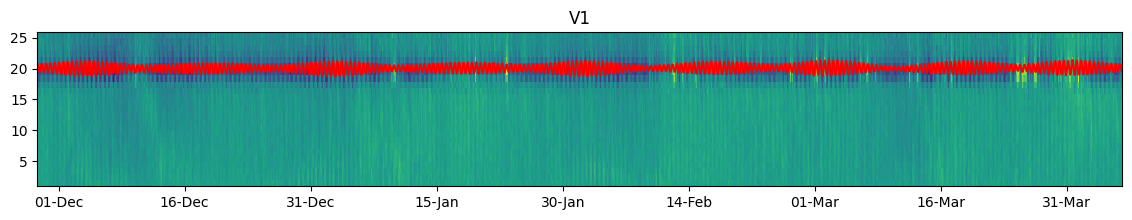

In [17]:
fig, ax = plt.subplots(figsize=(14,2))
ax.pcolormesh(time, niveis, v1.T)
ax.set_title('V1')
ax.plot(time,sen[:,13],'r')

ax.xaxis.set_major_locator(mdates.DayLocator(interval=15))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b'))
plt.show()

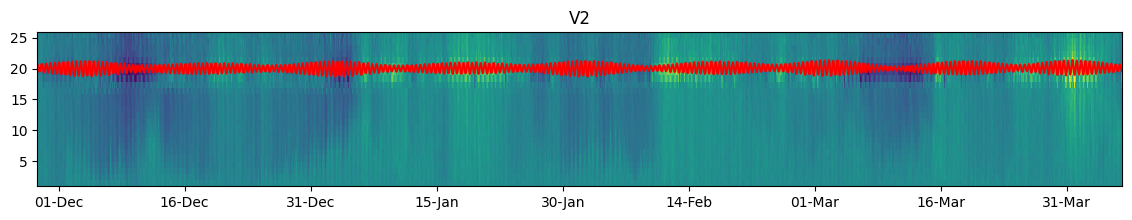

In [18]:
fig, ax = plt.subplots(figsize=(14,2))
ax.pcolormesh(time, niveis, v2.T)
ax.set_title('V2')
ax.plot(time,sen[:,13],'r')

ax.xaxis.set_major_locator(mdates.DayLocator(interval=15))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b'))
plt.show()

The amplitude signal above is what we expected from a 'well-behavior' data set... the amplitude decreases from the transducer and there is a peak at the surface!

### Cutting the bad data! 

The simplest way to eliminate the near surface and out of water data from the vertical profiles is by try and error elimitate the latter columnas of the matrixes. 

In [19]:
i = -10
niveis2 = niveis[:i]
amp2 = amp[:,:i]
v12 = v1[:,:i]
v22 = v2[:,:i]

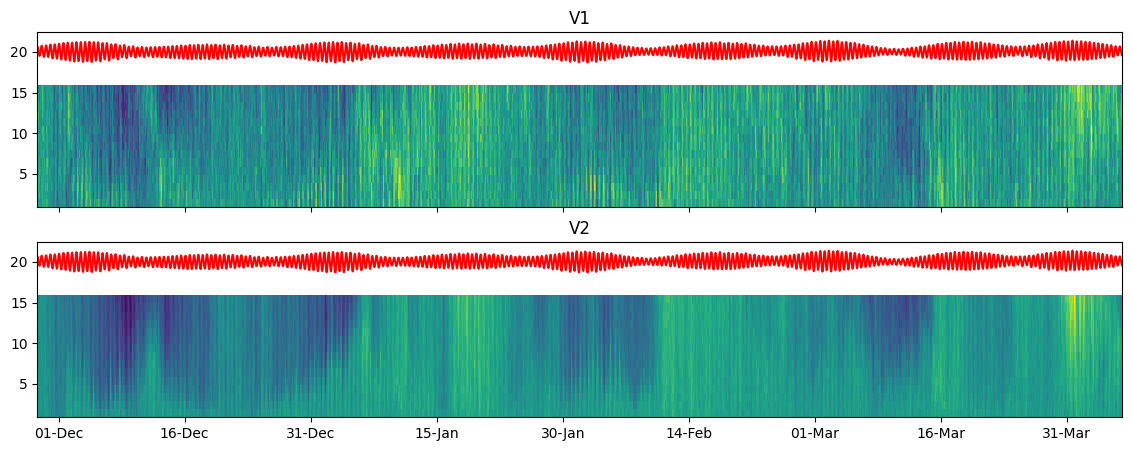

In [20]:
fig, axs = plt.subplots(2, figsize=(14,5))
axs[0].pcolormesh(time, niveis2, v12.T)
axs[0].set_title('V1')
axs[0].plot(time,sen[:,13],'r')

axs[1].pcolormesh(time, niveis2, v22.T)
axs[1].set_title('V2')
axs[1].plot(time,sen[:,13],'r')

for ax in axs:
    ax.xaxis.set_major_locator(mdates.DayLocator(interval=15))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b'))

axs[0].set_xticklabels('')
plt.show()

For the currents, we can also rotate the data to separate the maximum variance (longshore) from the minimum variance (cross-shore) components

here https://gutoschettini.github.io/Data-Analysis-with-Python/Schettini_20211101_vetores.pdf I present some ways to do this... one easy way is just ploting the coponentes and rotate manually until the points clouds fits over one may axis!

The 'red' dots in the figure below are the rotated data!

In [21]:
'''
The 'vecto_tools' package have some utilities... write me if you want a copy. 
'''
u, v = vt.vector_rotation(v12, v22, -17)

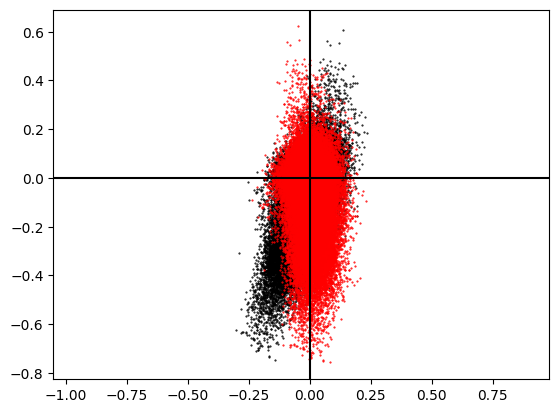

In [22]:
plt.plot(v12, v22, 'k.', ms=1)
plt.plot(u, v, 'r.', ms=1)
plt.axis('equal')
plt.axvline(0, color='k')
plt.axhline(0, color='k')
plt.show()

In [23]:
'''
Checking the sampling interval
'''
time[1]-time[0]

datetime.timedelta(seconds=3600)

In [24]:
'''
Low pass filtering
'''
order = 5
cut_freq = 1/30 # 30 hours
sampling_freq = 1 # hour

b, a = signal.butter(order, cut_freq, fs = sampling_freq,  btype = 'lowpass')

li, co = u.shape
uf = np.zeros((li, co))
vf = np.zeros((li, co))

for c in range(co):
    uf[:,c] = signal.filtfilt(b, a, u[:,c])
    vf[:,c] = signal.filtfilt(b, a, v[:,c])

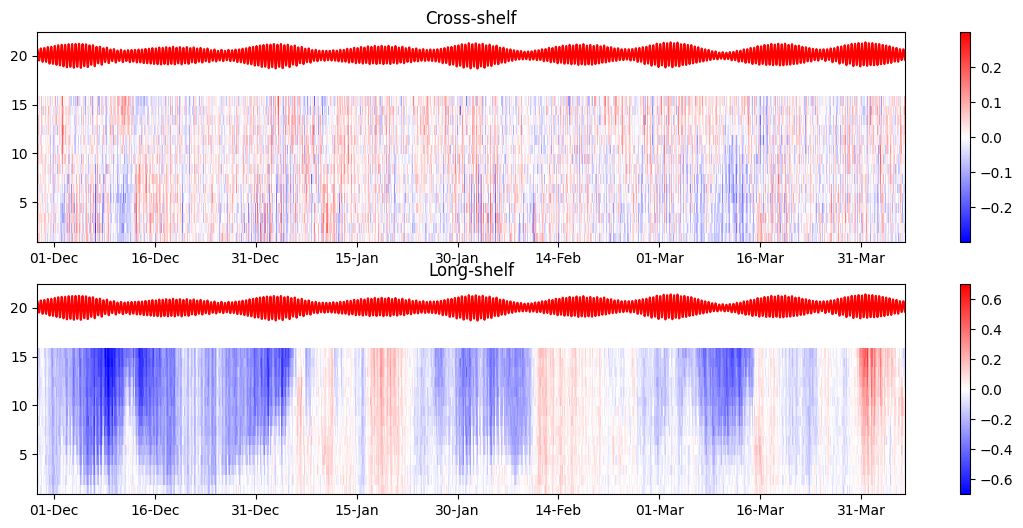

In [25]:
fig, axs = plt.subplots(2, figsize=(14,6))

norm = colors.TwoSlopeNorm(vmin = -0.3, vcenter = 0, vmax = 0.3)
cb1 = axs[0].pcolormesh(time,niveis2,u.T, cmap='bwr', norm=norm)
axs[0].set_title('Cross-shelf')
axs[0].plot(time,sen[:,13],'r')
plt.colorbar(cb1)

norm = colors.TwoSlopeNorm(vmin = -0.7, vcenter = 0, vmax = 0.7)
cb2 = axs[1].pcolormesh(time,niveis2,v.T, cmap='bwr', norm=norm)
axs[1].set_title('Long-shelf')
axs[1].plot(time,sen[:,13],'r')
plt.colorbar(cb2)

for ax in axs:
    ax.xaxis.set_major_locator(mdates.DayLocator(interval=15))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b'))

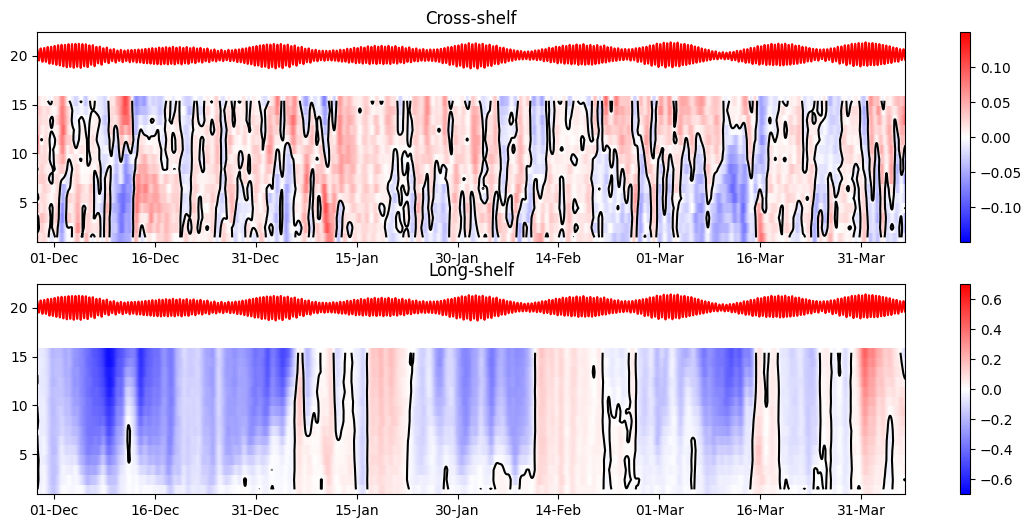

In [26]:
fig, axs = plt.subplots(2, figsize=(14,6))

norm = colors.TwoSlopeNorm(vmin = -0.15, vcenter = 0, vmax = 0.15)
cb1 = axs[0].pcolormesh(time,niveis2,uf.T, cmap='bwr', norm=norm)
axs[0].contour(time, niveis2, uf.T, [0], colors='k')
axs[0].set_title('Cross-shelf')
axs[0].plot(time,sen[:,13],'r')
plt.colorbar(cb1)

norm = colors.TwoSlopeNorm(vmin = -0.7, vcenter = 0, vmax = 0.7)
cb2 = axs[1].pcolormesh(time,niveis2,vf.T, cmap='bwr', norm=norm)
axs[1].contour(time, niveis2, vf.T, [0], colors='k')
axs[1].set_title('Long-shelf')
axs[1].plot(time,sen[:,13],'r')
plt.colorbar(cb2)

for ax in axs:
    ax.xaxis.set_major_locator(mdates.DayLocator(interval=15))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b'))